In [1]:
import glob
import cv2 as cv
import image_utils as imu
import ml_utils as mlu
import numpy as np 
import joblib

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV


from skimage.feature import hog
import matplotlib.pyplot as plt

In [3]:
# ML models to be tested
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Feature descriptors

# here are the hog descriptor from the openCV tutorial for better understanding
# https://docs.opencv.org/trunk/dd/d3b/tutorial_py_svm_opencv.html

SZ=28
bin_n = 16 # Number of bins
affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR


# this function uses image moments to straighten skewed images 
def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img


# the Histogram of Oriented Gradients is a good descriptor for image "shapes"
# we will use the hog descriptor from scikit-image, but here is an example of how it is done
def fd_hog(img):
    # first we calculate horizontal and vertical gradients
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    # then we find the magnetude and directionf of the gradients
    mag, ang = cv.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    # generate the histogram
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)  # hist is a 64 bit vector
    return hist


# Load data

In [6]:
import tensorflow as tf
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = tf.keras.datasets.mnist.load_data()

# Visualiza your data

train size: 60000, test size: 10000
8


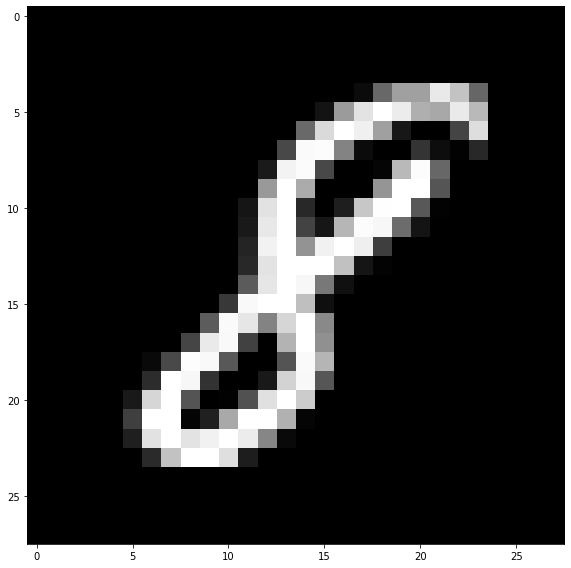

In [7]:
print("train size: {}, test size: {}".format(len(mnist_x_train), len(mnist_x_test)))
image_index = 7777
print(mnist_y_train[image_index])
imu.show(mnist_x_train[image_index])

# Visualize your Feature Engineering

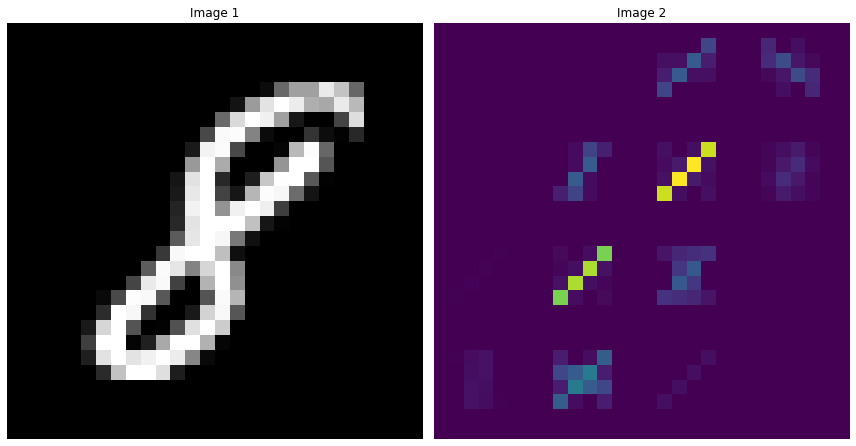

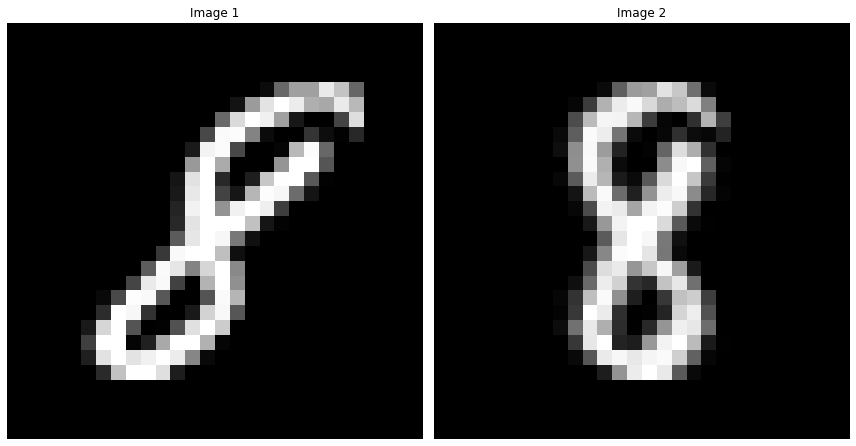

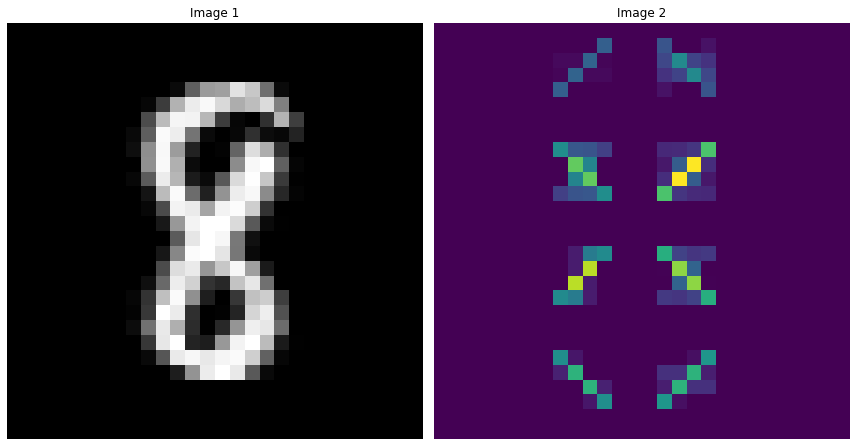

In [8]:
# Define pixels_per_cell part
ppc = 7

# the image without deskew
hog(mnist_x_train[image_index])
fd,hog_image = hog(mnist_x_train[image_index], orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
imu.show_comparison(mnist_x_train[image_index],hog_image)

deskew_img = deskew(mnist_x_train[image_index])
fd,hog_image = hog(deskew_img, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
# the deskewed image looks better
imu.show_comparison(mnist_x_train[image_index],deskew_img, cmap='gray')
# its hog features seems better with deskew
imu.show_comparison(deskew_img, hog_image)


# Calculate Features

In [9]:
# Use custom transformers created in ml_utils module
import ml_utils as mlu
from ml_utils.transformers import DeSkewTransformer, HogTransformer
from sklearn.pipeline import Pipeline

# create a pipeline with the sequence of deskew followed by hog
hog_pipeline = Pipeline([
        ('deskew', DeSkewTransformer()),
        ('HOG', HogTransformer()),
        ('Std_Scaler', StandardScaler())
    ])

mnist_transform_train = hog_pipeline.fit_transform(mnist_x_train)
mnist_transform_test = hog_pipeline.fit_transform(mnist_x_test)
labels = np.array(mnist_y_train).ravel()
print(mnist_transform_train.shape)

(60000, 128)


# Evaluate Relevance of Features

In [10]:
sc = StandardScaler()
X_train_std = sc.fit_transform(mnist_transform_train)
X_test_std = sc.transform(mnist_transform_test)

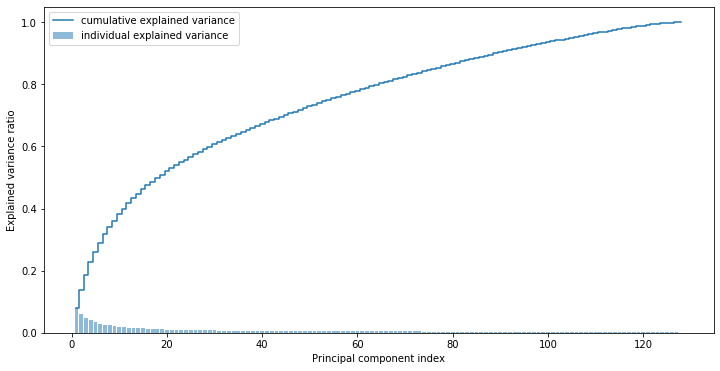

In [11]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# calculate cumulative sum of explained variances
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
# on next plot we can see that even though the individual explained variance diminishes
# the cumulative explained variance still grows showing that the 128 calculated features are somewhat relevant
plt.figure(figsize=(12, 6))
plt.bar(range(1,len(var_exp)+1), var_exp, alpha=0.5,align='center', label='individual explained variance')
plt.step(range(1,len(var_exp)+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set()

pca = PCA(n_components=10) 
transformed = pca.fit_transform(mnist_transform_train)

print(transformed.shape)

(60000, 10)


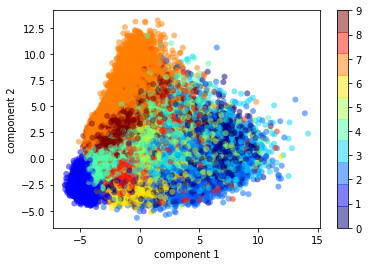

In [13]:
# here we can see the plot of the dimensionality reduction of the first 2 out of 10 PCA components
plt.scatter(transformed[:, 0], transformed[:, 1],
            c=labels.ravel(), edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

# Train, Test splits and Shuffle

In [14]:
# Shuffle data

# for faster grid search only 5000 samples will be used for training
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(
    mnist_transform_train, labels, test_size=0.91666, random_state = 42)

print(X_train_min.shape, y_train_min.shape)
print(X_test_min.shape, y_test_min.shape)

(5000, 128) (5000,)
(55000, 128) (55000,)


# Model Testing with Cross-Validation


Very important when the dataset is small and we want to better estimate the generalization error of our model over the dataset

Notice though that it may take a lot of extra time to train multiple models.

# Grid Search with Cross-Validation

In [15]:
# Set the parameters by cross-validation
from pandas import DataFrame
# global results, ensemble_models, X_train, y_train, X_test, y_test, scoring
results = DataFrame(columns=['Model','Parameters','Test_Score','CV Mean','CV STDEV'])
ensemble_models = {}
scoring = "f1_macro"

model_name = "svc"
tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['rbf'], 'gamma': [10, 1, 1e-1, 1e-2], 'C': [1, 10, 100, 1000]}]

hp_scores = ["accuracy", "f1_macro"]

# Grid Search for Support Vector Classification

In [16]:
for score in hp_scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    grid = GridSearchCV(SVC(), tuned_parameters, cv=2, scoring='%s' % score)
    grid.fit(X_train_min, y_train_min)

    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.5f (+/-%0.05f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_min, grid.predict(X_test_min)
    print(classification_report(y_true, y_pred))
    print()



# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.94980 (+/-0.00200) for {'C': 1, 'kernel': 'linear'}
0.95040 (+/-0.00160) for {'C': 10, 'kernel': 'linear'}
0.95040 (+/-0.00160) for {'C': 100, 'kernel': 'linear'}
0.95040 (+/-0.00160) for {'C': 1000, 'kernel': 'linear'}
0.11160 (+/-0.00000) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.11160 (+/-0.00000) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.55520 (+/-0.01680) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.93000 (+/-0.01120) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.11160 (+/-0.00000) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.11160 (+/-0.00000) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.58300 (+/-0.00760) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.93580 (+/-0.00600) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.11160 (+/-0.00000) for {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
0.11160 (+/-0.00000) for {'C': 100, 'gamm

# Train best hyperparameter model

In [17]:
grid.best_estimator_.fit(mnist_transform_train, mnist_y_train)
scores = cross_val_score(grid.best_estimator_, mnist_transform_train, mnist_y_train, cv=5, 
                         scoring='%s' % scoring, verbose=0)

CV_scores = scores.mean()
STDev = scores.std()
Test_scores = grid.score(mnist_transform_test, mnist_y_test)

cv_score = {'Model_Name': model_name,'Parameters': grid.best_params_,'Test_Score': Test_scores,
              'CV Mean':CV_scores, 'CV STDEV': STDev}
# CV and Save scores
results = results.append(cv_score, ignore_index=True)
ensemble_models[model_name] = grid.best_estimator_

# Print Evaluation
print("\nEvaluation Method: {}".format(scoring))
print("Optimal Model Parameters: {}".format(grid.best_params_))
print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (CV_scores, STDev, model_name))
print('Test_Score:', Test_scores)

clf = grid.best_estimator_.fit(mnist_transform_train, mnist_y_train)
clf.score(mnist_transform_test, mnist_y_test)


Evaluation Method: f1_macro
Optimal Model Parameters: {'C': 10, 'kernel': 'linear'}
Train CV Accuracy: 0.97 (+/- 0.00) [svc]
Test_Score: 0.9709693073036869


0.971

# Testing

After we validate our model, normally I separate new data which the model has never been trained before in order to test our model. In this case I will use the original separated test data from the dataset for testing afver validating with training split.

In [18]:
y_pred = clf.predict(mnist_transform_test)


print("Accuracy: "+str(accuracy_score(mnist_y_test, y_pred)))
print('\n')
clf_report = classification_report(mnist_y_test, y_pred)
print(clf_report)

Accuracy: 0.971


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.98      0.97      1010
           4       0.96      0.97      0.96       982
           5       0.98      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.96      0.97      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.97      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# Visualize errors

Sometimes you want to visualize what kind of errors the model did in order to add features and make it better

Total errors on this class: 6


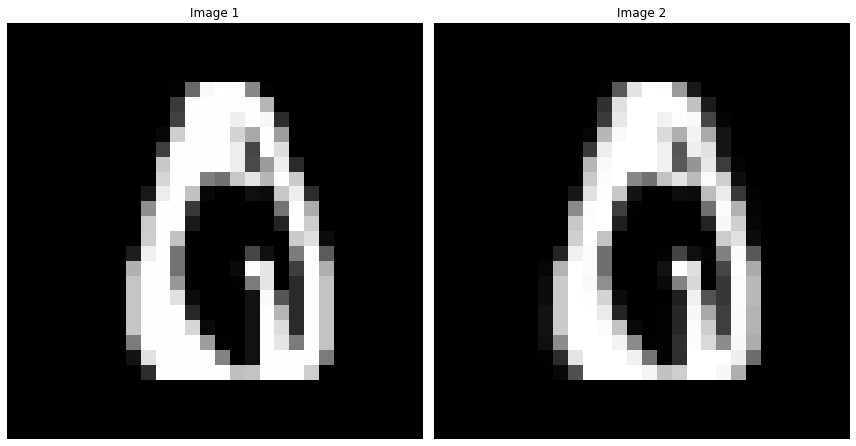

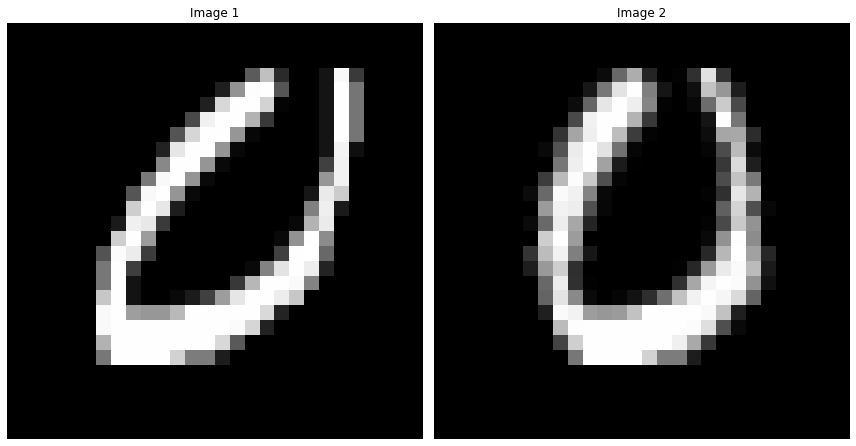

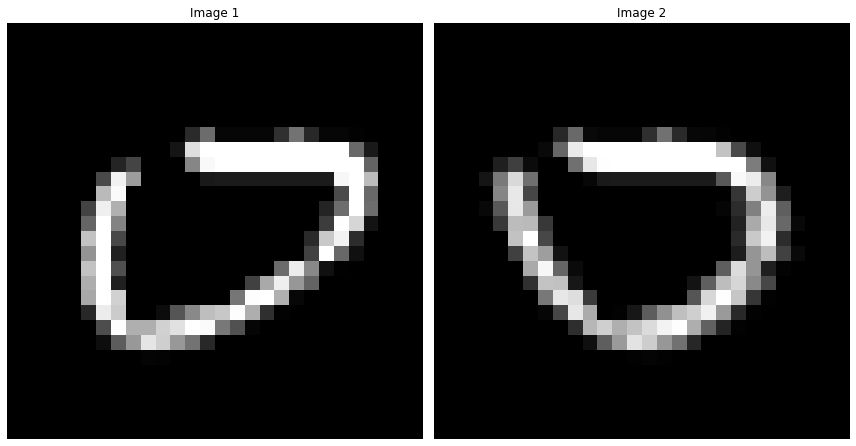

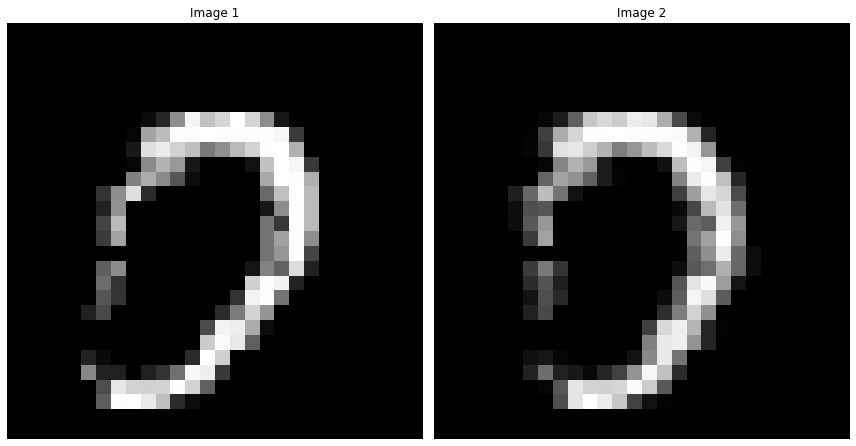

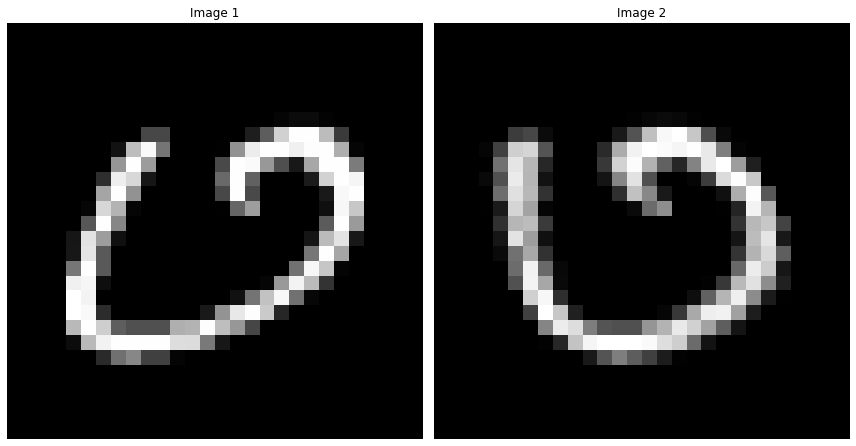

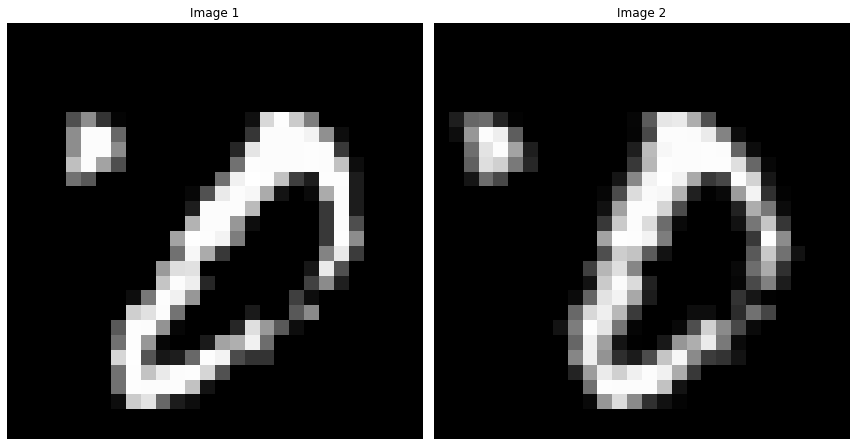

In [19]:
err_vec = [i for i, x in enumerate(y_pred) if mnist_y_test[i] != y_pred[i] and mnist_y_test[i]==0]
print("Total errors on this class: {}".format(len(err_vec)))

for i in range(len(err_vec[:10])):
    imu.show_comparison(mnist_x_test[err_vec[i]], deskew(mnist_x_test[err_vec[i]]), cmap='gray')

# Save Model

The joblib package is the most common choice for saving sklearn models. The method joblib.dumps saves python objects. For future comparrison I will save some metadata with the models in the method 'save' from ml_utils.

In [20]:
mlu.save(clf, cv_score, clf_report, name=model_name)

# Loading 

In [21]:
model = mlu.load(model_name)


Loading model with the following info:

Model_Name: svc
Parameters: {'C': 10, 'kernel': 'linear'}
Test_Score: 0.9709693073036869
CV Mean: 0.9677553245710284
CV STDEV: 0.002135681370747115

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.98      0.97      1010
           4       0.96      0.97      0.96       982
           5       0.98      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.96      0.97      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.97      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

